# Importing Required Libraries

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
import math

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# Reading and Cleaning Data

In [2]:
def generate_labels(row): #Function to generate labels (1 to 6) from Activity Names
    if row['Activity'] == "WALKING":
        return 1
    elif row['Activity'] == "WALKING_UPSTAIRS":
        return 2
    elif row['Activity'] == "WALKING_DOWNSTAIRS":
        return 3
    elif row['Activity'] == "SITTING":
        return 4
    elif row['Activity'] == "STANDING":
        return 5
    if row['Activity'] == "LAYING":
        return 6
        
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

#Checking for Duplicates
print('Duplicates in train: ', sum(train.duplicated()))
print('Duplicates in test : ', sum(test.duplicated()))
print()


#Checking for Null Values
print('Null values in train: ',train.isnull().values.sum())
print('Null values in test: ',test.isnull().values.sum())
print()

#Generating Labels
labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]
train['ActivityLabel'] =train.apply (lambda row: generate_labels(row), axis=1)
test['ActivityLabel'] =test.apply (lambda row: generate_labels(row), axis=1)
print("Train.shape: ", train.shape)
print("Test.shape: ", test.shape)
print()

#Constructing X,y train and test variables.
X_train = train.drop(['subject', 'Activity', 'ActivityLabel'], axis=1)
y_train = train.ActivityLabel

X_test = test.drop(['subject', 'Activity','ActivityLabel'], axis=1)
y_test = test.ActivityLabel

print('X_train and y_train: {} and {}'.format(X_train.shape, y_train.shape))
print('X_test and y_test: {} and {}'.format(X_test.shape, y_test.shape))

labelnums = [i for i in range(1,7)]

print("\nActivities and their associated labels: \n", dict(zip(labels,labelnums)))

Duplicates in train:  0
Duplicates in test :  0

Null values in train:  0
Null values in test:  0

Train.shape:  (7352, 564)
Test.shape:  (2947, 564)

X_train and y_train: (7352, 561) and (7352,)
X_test and y_test: (2947, 561) and (2947,)

Activities and their associated labels: 
 {'WALKING': 1, 'WALKING_UPSTAIRS': 2, 'WALKING_DOWNSTAIRS': 3, 'SITTING': 4, 'STANDING': 5, 'LAYING': 6}


# Exploratory Data Analysis

## Checking if the data is balanced
After plotting a BarPlot for the entire data set and piecharts for training and test data, we can observe that the data is fairly balanced

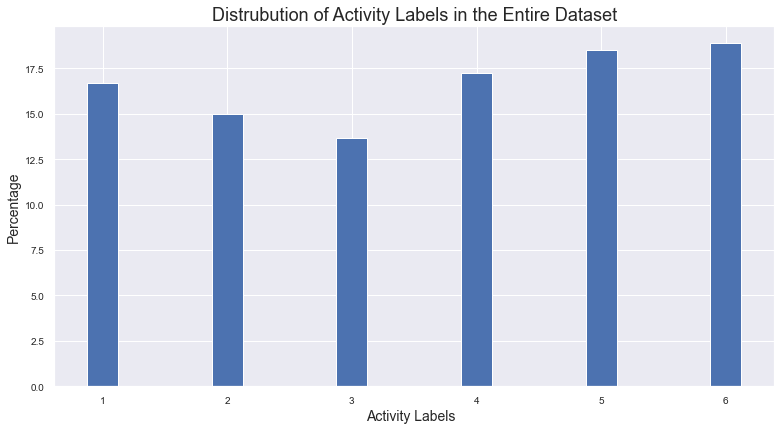

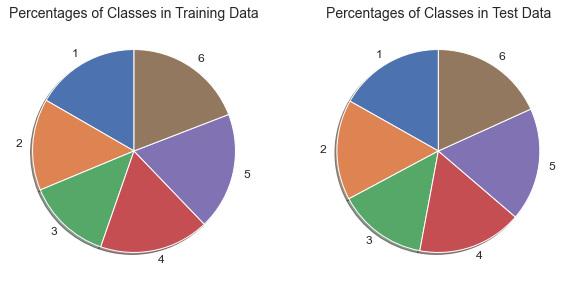

In [12]:
total = pd.concat([train,test])
df_total = pd.DataFrame(total)
group_total = df_total.groupby('ActivityLabel').size()
group_total = group_total.values

percentages = []
classes = []
for i in range(len(group_total)):
    percent = group_total[i] / len(total) * 100
    percentages.append(percent)
    classes.append(i+1)

# Plotting BarPlot for the entire dataset
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Percentage',fontsize=14)
ax.set_xlabel('Activity Labels  ',fontsize=14)
ax.set_title('Distrubution of Activity Labels in the Entire Dataset',fontsize=18)
ax.tick_params(labelsize=10)
ax.bar(classes, percentages, color = 'b', width = 0.25)
plt.show()


# Plotting PieCharts for Training and Test Data
df_train = pd.DataFrame(y_train)
df_test = pd.DataFrame(y_test)
group_train = df_train.groupby('ActivityLabel').size()
group_train = group_train.values
group_test = df_test.groupby('ActivityLabel').size()
group_test = group_test.values

percentages = []
classes = []
for i in range(len(group_train)):
    percent = group_train[i] / len(y_train) * 100
    percentages.append(percent)
    classes.append(i+1)

plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(1, 2, 1)
plt.title("Percentages of Classes in Training Data",fontdict = {'fontsize' : 14})
plt.pie(percentages,labels = classes,startangle = 90,shadow = True, textprops={'fontsize': 12})


percentages = []
for i in range(len(group_test)):
    percent = group_test[i] / len(y_test) * 100
    percentages.append(percent)

plt.subplot(1, 2, 2)
plt.title("Percentages of Classes in Test Data",fontdict = {'fontsize' : 14})
plt.pie(percentages,labels = classes,startangle = 90,shadow = True,textprops={'fontsize': 12})
plt.show()

## Static and Dynamic Activities 
In the given datasets, we have 6 activities in total namely: WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING

Out of these, 3 are static activities which do not require any movement: SITTING, STANDING, LAYING

The rest are dynamic activities which do require movement: WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS

So this section explores the distribution of static and dynamic samples by plotting average reading of the accelerometer from smartphones

Shape of static dataframe:  (5627, 564)
Shape of dynamic dataframe:  (4672, 564)

Percentage of Static and Dynamic Samples:  54.636372463345964 45.36362753665404


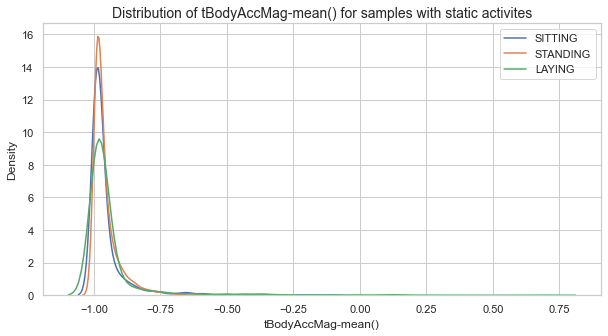

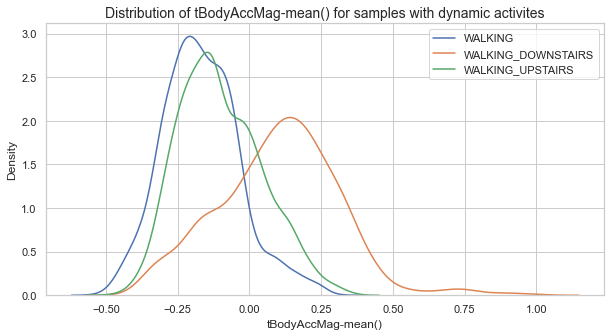

In [4]:
total = pd.concat([train,test])
df_total = pd.DataFrame(total)

#Constructing dynamic and static dataframes
static_list = [4,5,6]
dynamic_list = [1,2,3]
bool_static = df_total.ActivityLabel.isin(static_list)
bool_dynamic = df_total.ActivityLabel.isin(dynamic_list)

df_static = df_total[bool_static]
df_dynamic = df_total[bool_dynamic]

print("Shape of static dataframe: ",df_static.shape)
print("Shape of dynamic dataframe: ",df_dynamic.shape)

print()
print("Percentage of Static and Dynamic Samples: ",(df_static.shape[0]/df_total.shape[0])*100,(df_dynamic.shape[0]/df_total.shape[0])*100)


# GroupingBy Activity Labels
df_static.drop(df_static.columns.difference(['tBodyAccMag-mean()','ActivityLabel']), 1, inplace=True)
static_group = df_static.groupby('ActivityLabel')
df_dynamic.drop(df_dynamic.columns.difference(['tBodyAccMag-mean()','ActivityLabel']), 1, inplace=True)
dynamic_group = df_dynamic.groupby('ActivityLabel')

walking = dynamic_group.get_group(1)
walking_u = dynamic_group.get_group(2)
walking_d = dynamic_group.get_group(3)
sitting = static_group.get_group(4)
standing = static_group.get_group(5)
laying = static_group.get_group(6)


# Plotting Static Df
sns.set()
sns.set_style('whitegrid')
fig, ax = plt.subplots()

ax = sns.kdeplot(data=sitting['tBodyAccMag-mean()'], label='SITTING', ax=ax)
ax = sns.kdeplot(data=standing['tBodyAccMag-mean()'], label='STANDING', ax=ax)
ax = sns.kdeplot(data=laying['tBodyAccMag-mean()'], label='LAYING', ax=ax)

ax.set_title('Distribution of tBodyAccMag-mean() for samples with static activites',fontsize=14)
plt.legend()
plt.show()

# Plotting Dynamic Df
sns.set_style('whitegrid')
fig, ax = plt.subplots()

ax = sns.kdeplot(data=walking['tBodyAccMag-mean()'], label='WALKING', ax=ax)
ax = sns.kdeplot(data=walking_d['tBodyAccMag-mean()'], label='WALKING_DOWNSTAIRS', ax=ax)
ax = sns.kdeplot(data=walking_u['tBodyAccMag-mean()'], label='WALKING_UPSTAIRS', ax=ax)

ax.set_title('Distribution of tBodyAccMag-mean() for samples with dynamic activites',fontsize=14)
plt.legend()
plt.show()

# Helper Functions

In [5]:
def apply_model(model, X_train, y_train, X_test, y_test, labels): #Function to apply models
    
    
    performance = dict() #Record the performance of the model while applying it
    
    # Training the model
    start = datetime.now()
    print('\n****************Training Start****************')
    model.fit(X_train, y_train)
    stop = datetime.now()
    print('****************Training Finish****************')
    duration = stop - start
    performance['training_time'] =  duration
    print("Training Time: ", duration)
    print()
    
    
    # Testing the model
    print('\n****************Testing Start****************')
    start = datetime.now()
    y_pred = model.predict(X_test)
    stop = datetime.now()
    performance['TestPredictions'] = y_pred
    print('****************Testing Finish****************')
    duration = stop - start
    performance['testing_time'] =  duration
    print("Testing Time: ", duration)
    print()
   

    # Computing Metrics

    # ConfusionMatrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('\n****************Confusion Matrix****************')
    print(conf_matrix)
    print()
    performance['confusion_matrix'] = conf_matrix
    
    # Plotting Confusion Matrix
    sns.set()
    ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

    ax.set_title('Confusion Matrix\n',size=18,weight='bold')
    ax.set_xlabel('\nPredicted Labels',fontdict = {'fontsize' : 14,'weight': 'bold'})
    ax.set_ylabel('True Labels ',fontdict = {'fontsize' : 14,'weight': 'bold'})

    ax.xaxis.set_ticklabels(labels,rotation=45)
    ax.yaxis.set_ticklabels(labels,rotation=0)
    plt.show()
    
    # Classification Report
    print('**************** Classifiction Report ****************')
    classification_report = metrics.classification_report(y_test, y_pred)
    performance['classification_report'] = classification_report
    print(classification_report)
    print()
    
    # Accuracy
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    print('**************** Accuracy ****************')
    print(accuracy)
    print()
    performance['accuracy'] = accuracy


    # Add the trained  model to the performance dictionary
    performance['model'] = model
    
    return performance

def gs_report(model): #Function to generate the report for grid search
    print('\nBest Estimator: ',model.best_estimator_)

    print('\nBest parameters: ',model.best_params_)


    print('\nTotal number of CrossValidation sets: ',model.n_splits_)

    print('\nBest Score: ',model.best_score_)
    
    print()


# Applying Models

## Majority-Guess [Baseline]
According to our exploratory data analysis charts, although the data is balanced, we can see that the majority of the targets belong to the class 6 ('Laying'). So as a trivial baseline model, we will implement a model predicting the majority guess for all the test data i.e. predicting 6 for the test data


****************Confusion Matrix****************
[[  0   0   0   0   0 496]
 [  0   0   0   0   0 471]
 [  0   0   0   0   0 420]
 [  0   0   0   0   0 491]
 [  0   0   0   0   0 532]
 [  0   0   0   0   0 537]]



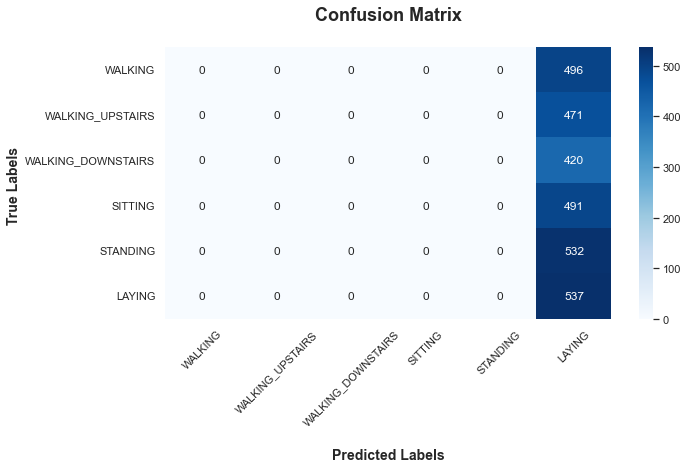

**************** Accuracy ****************
0.18221920597217509



In [6]:
prediction_list = [6 for _ in range(y_test.shape[0])] #Predicting majority guess
y_pred = pd.Series(prediction_list)
conf_matrix = confusion_matrix(y_test,y_pred)
print('\n****************Confusion Matrix****************')
print(conf_matrix)
print()

# Plotting confusion matrix
sns.set()
ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

ax.set_title('Confusion Matrix\n',size=18,weight='bold')
ax.set_xlabel('\nPredicted Labels',fontdict = {'fontsize' : 14,'weight': 'bold'})
ax.set_ylabel('True Labels ',fontdict = {'fontsize' : 14,'weight': 'bold'})

ax.xaxis.set_ticklabels(labels,rotation=45)
ax.yaxis.set_ticklabels(labels,rotation=0)
plt.show()

accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
print('**************** Accuracy ****************')
print(accuracy)
print()

trivial_results = dict()
trivial_results['accuracy'] = accuracy

## Softmax Regression


****************Training Start****************
Fitting 3 folds for each of 12 candidates, totalling 36 fits
****************Training Finish****************
Training Time:  0:00:09.230041


****************Testing Start****************
****************Testing Finish****************
Testing Time:  0:00:00.007999


****************Confusion Matrix****************
[[492   1   3   0   0   0]
 [ 24 445   2   0   0   0]
 [  4  13 403   0   0   0]
 [  0   3   0 430  58   0]
 [  0   0   0  17 515   0]
 [  0   0   0   0   0 537]]



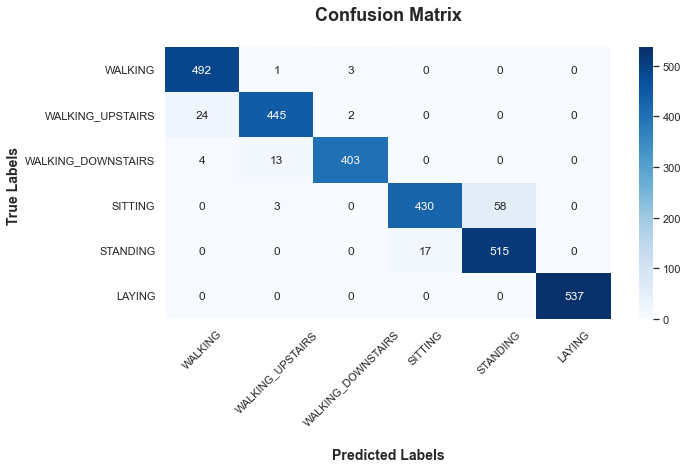

**************** Classifiction Report ****************
              precision    recall  f1-score   support

           1       0.95      0.99      0.97       496
           2       0.96      0.94      0.95       471
           3       0.99      0.96      0.97       420
           4       0.96      0.88      0.92       491
           5       0.90      0.97      0.93       532
           6       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947


**************** Accuracy ****************
0.9575839837122497

**************** GridSearch Report ****************

Best Estimator:  LogisticRegression(C=1, multi_class='multinomial', verbose=False)

Best parameters:  {'C': 1, 'penalty': 'l2'}

Total number of CrossValidation sets:  3

Best Score:  0.9366175682839435



In [7]:

# Implement GridSearch on the given parameters
parameters = {'C':[0.01, 0.1, 1, 10, 20, 30], 'penalty':['l2','l1']}
softmax_model = linear_model.LogisticRegression(verbose=False,multi_class='multinomial')
softmax_model_gs = GridSearchCV(softmax_model, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)

softmax_results =  apply_model(softmax_model_gs, X_train, y_train, X_test, y_test, labels)

print('**************** GridSearch Report ****************')
gs_report(softmax_results['model'])

## Kernel SVM (rbf)


****************Training Start****************
****************Training Finish****************
Training Time:  0:04:20.629491


****************Testing Start****************
****************Testing Finish****************
Testing Time:  0:00:01.149547


****************Confusion Matrix****************
[[489   5   2   0   0   0]
 [ 17 453   1   0   0   0]
 [  4  19 397   0   0   0]
 [  0   2   0 441  48   0]
 [  0   0   0  12 520   0]
 [  0   0   0   0   0 537]]



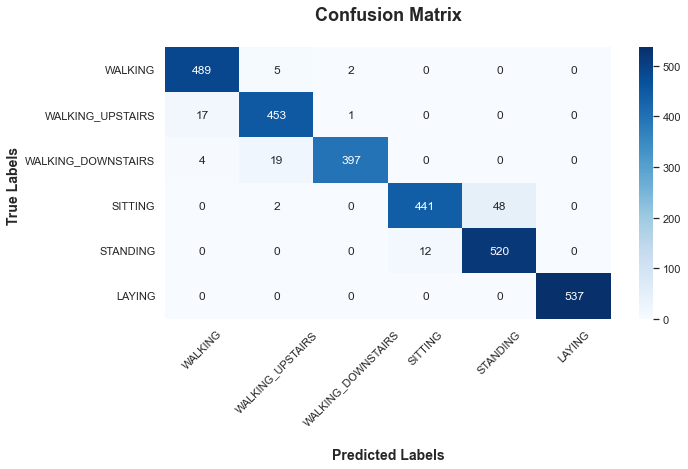

**************** Classifiction Report ****************
              precision    recall  f1-score   support

           1       0.96      0.99      0.97       496
           2       0.95      0.96      0.95       471
           3       0.99      0.95      0.97       420
           4       0.97      0.90      0.93       491
           5       0.92      0.98      0.95       532
           6       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947


**************** Accuracy ****************
0.9626739056667798

**************** GridSearch Report ****************

Best Estimator:  SVC(C=16, gamma=0.0078125)

Best parameters:  {'C': 16, 'gamma': 0.0078125}

Total number of CrossValidation sets:  5

Best Score:  0.9447834551903698



In [8]:
parameters = {'C':[2,8,16],'gamma': [ 0.0078125, 0.125, 2]}
svm_rbf_model = SVC(kernel='rbf')
svm_rbf_gs = GridSearchCV(svm_rbf_model,param_grid=parameters, n_jobs=-1)
svm_rbf_results = apply_model(svm_rbf_gs, X_train, y_train, X_test, y_test, labels)

print('**************** GridSearch Report ****************')
gs_report(svm_rbf_results['model'])

## Linear SVC


****************Training Start****************
Fitting 5 folds for each of 5 candidates, totalling 25 fits
****************Training Finish****************
Training Time:  0:00:29.823352


****************Testing Start****************
****************Testing Finish****************
Testing Time:  0:00:00.007996


****************Confusion Matrix****************
[[496   0   0   0   0   0]
 [ 17 454   0   0   0   0]
 [  3   5 412   0   0   0]
 [  0   3   0 428  58   2]
 [  1   0   0   9 522   0]
 [  0   0   0   0   0 537]]



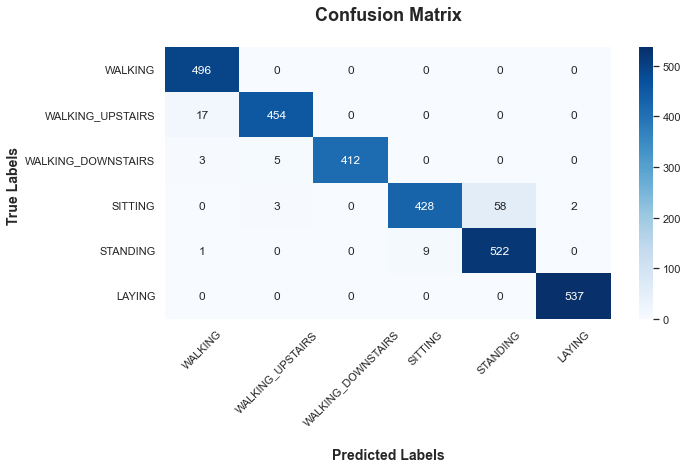

**************** Classifiction Report ****************
              precision    recall  f1-score   support

           1       0.96      1.00      0.98       496
           2       0.98      0.96      0.97       471
           3       1.00      0.98      0.99       420
           4       0.98      0.87      0.92       491
           5       0.90      0.98      0.94       532
           6       1.00      1.00      1.00       537

    accuracy                           0.97      2947
   macro avg       0.97      0.97      0.97      2947
weighted avg       0.97      0.97      0.97      2947


**************** Accuracy ****************
0.9667458432304038

**************** GridSearch Report ****************

Best Estimator:  LinearSVC(C=0.5, tol=5e-05)

Best parameters:  {'C': 0.5}

Total number of CrossValidation sets:  5

Best Score:  0.942200455981169



In [9]:
parameters = {'C':[0.125, 0.5, 1, 2, 8]}
linear_svc = LinearSVC(tol=0.00005)
linear_svc_gs = GridSearchCV(linear_svc, param_grid=parameters, n_jobs=-1, verbose=1)
linear_svc_results = apply_model(linear_svc_gs, X_train, y_train, X_test, y_test, labels)

print('**************** GridSearch Report ****************')
gs_report(linear_svc_results['model'])

## Random Forest Classifier


****************Training Start****************
****************Training Finish****************
Training Time:  0:04:11.093962


****************Testing Start****************
****************Testing Finish****************
Testing Time:  0:00:00.049987


****************Confusion Matrix****************
[[481   4  11   0   0   0]
 [ 42 423   6   0   0   0]
 [ 21  42 357   0   0   0]
 [  0   0   0 440  51   0]
 [  0   0   0  37 495   0]
 [  0   0   0   0   0 537]]



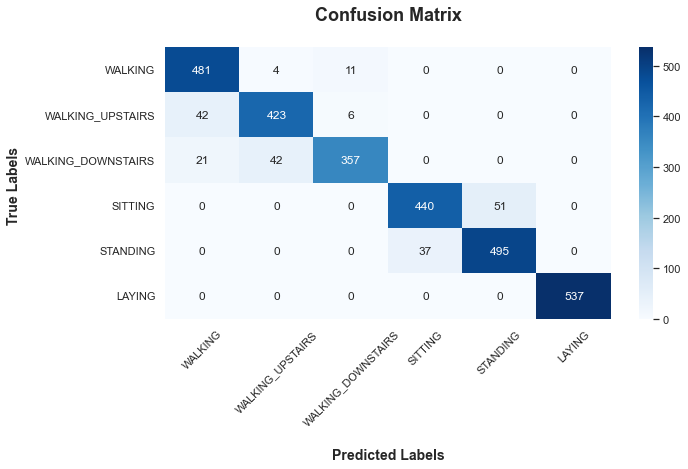

**************** Classifiction Report ****************
              precision    recall  f1-score   support

           1       0.88      0.97      0.92       496
           2       0.90      0.90      0.90       471
           3       0.95      0.85      0.90       420
           4       0.92      0.90      0.91       491
           5       0.91      0.93      0.92       532
           6       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.92      0.93      2947
weighted avg       0.93      0.93      0.93      2947


**************** Accuracy ****************
0.9273837801153716

**************** GridSearch Report ****************

Best Estimator:  RandomForestClassifier(max_depth=11, n_estimators=110)

Best parameters:  {'max_depth': 11, 'n_estimators': 110}

Total number of CrossValidation sets:  5

Best Score:  0.9226103765775514



In [10]:
params = {'n_estimators': np.arange(10,201,20), 'max_depth':np.arange(3,15,2)}
random_forest = RandomForestClassifier()
rf_gs = GridSearchCV(random_forest, param_grid=params, n_jobs=-1)
rf_results = apply_model(rf_gs, X_train, y_train, X_test, y_test, labels)

print('**************** GridSearch Report ****************')
gs_report(rf_results['model'])

# Conclusion
Comparing all the models with their accuracies, we can choose Linear SVC for our predictions since it has the highest accuracy compared to al the other models

           Model  Accuracy
0       Baseline     18.22
1        Softmax     95.76
2     RBF Kernel     96.27
3     Linear SVC     96.67
4  Random Forest     92.74


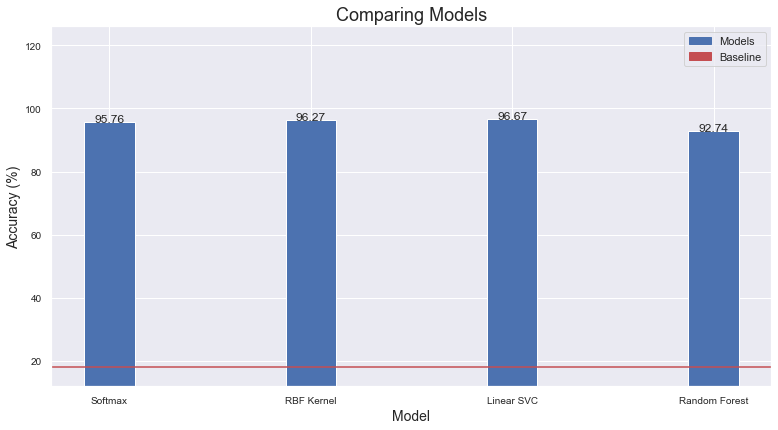

In [11]:
accuracies = [] #List of all the accuracies rounded off to 2 decimal places
accuracies.append(round(trivial_results['accuracy']*100,2))
accuracies.append(round(softmax_results['accuracy']*100,2))
accuracies.append(round(svm_rbf_results['accuracy']*100,2))
accuracies.append(round(linear_svc_results['accuracy']*100,2))
accuracies.append(round(rf_results['accuracy']*100,2))

model_names = ['Baseline', 'Softmax', 'RBF Kernel', 'Linear SVC', 'Random Forest']

df = pd.DataFrame({'Model':model_names,'Accuracy': accuracies})
print(df)

accuracies = accuracies[1:]
model_names = model_names[1:]

# Plotting BarPlot with Models and Baseline
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Accuracy (%)',fontsize=14)
ax.set_xlabel('Model',fontsize=14)
ax.set_title('Comparing Models',fontsize=18)
ax.tick_params(labelsize=10)

for i in range(len(model_names)):
        plt.text(i, accuracies[i], accuracies[i], ha = 'center')

low = 40
high = max(accuracies)
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
ax.bar(model_names, accuracies, color = 'b', width = 0.25)
plt.axhline(y=round(trivial_results['accuracy']*100,2), color='r', linestyle='-')

colors = {'Models':'b', 'Baseline':'r'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show()

# Data set

https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones?resource=download

https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones


# References

#### Grid Search
https://medium.com/fintechexplained/what-is-grid-search-c01fe886ef0a

https://towardsdatascience.com/grid-search-for-hyperparameter-tuning-9f63945e8fec

#### Confusion Matrix
https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why


#### Pandas and Data Analysis
https://www.w3schools.com/python/matplotlib_pie_charts.asp

https://realpython.com/pandas-groupby/

https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas

https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/

https://stackoverflow.com/questions/59696944/density-plot-python-pandas

https://stackoverflow.com/questions/25328003/how-can-i-change-the-font-size-using-seaborn-facetgrid

#### Machine Learning Models

##### Softmax Regression
https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

https://towardsdatascience.com/softmax-function-simplified-714068bf8156


##### RBF Kernel SVM
https://www.ibm.com/docs/it/spss-modeler/SaaS?topic=models-how-svm-works

https://towardsdatascience.com/radial-basis-function-rbf-kernel-the-go-to-kernel-acf0d22c798a

https://towardsdatascience.com/svm-classifier-and-rbf-kernel-how-to-make-better-models-in-python-73bb4914af5b

https://dzone.com/articles/using-jsonb-in-postgresql-how-to-effectively-store-1

##### Linear SVC
https://towardsdatascience.com/svm-with-scikit-learn-what-you-should-know-780f1bc99e4a

https://www.datatechnotes.com/2020/07/classification-example-with-linearsvm-in-python.html

https://pythonprogramming.net/linear-svc-example-scikit-learn-svm-python/

https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/

##### Random Forest Classifier
https://towardsdatascience.com/a-practical-guide-to-implementing-a-random-forest-classifier-in-python-979988d8a263

https://www.datacamp.com/community/tutorials/random-forests-classifier-python

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74